<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Create-new-score" data-toc-modified-id="Create-new-score-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Create new score</a></span></li><li><span><a href="#Confusion-matrix" data-toc-modified-id="Confusion-matrix-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Confusion matrix</a></span></li><li><span><a href="#Scatter-plot" data-toc-modified-id="Scatter-plot-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Scatter plot</a></span></li><li><span><a href="#Details-on-each-problematic-classifications" data-toc-modified-id="Details-on-each-problematic-classifications-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Details on each problematic classifications</a></span><ul class="toc-item"><li><span><a href="#Ambiguous-classification" data-toc-modified-id="Ambiguous-classification-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Ambiguous classification</a></span></li><li><span><a href="#'Some'-category" data-toc-modified-id="'Some'-category-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>'Some' category</a></span></li><li><span><a href="#insufficient-evidence" data-toc-modified-id="insufficient-evidence-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>insufficient evidence</a></span></li><li><span><a href="#Wrongly-classified-jobs" data-toc-modified-id="Wrongly-classified-jobs-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Wrongly classified jobs</a></span><ul class="toc-item"><li><span><a href="#Description-of-the-wrongly-classify-as-Software-job" data-toc-modified-id="Description-of-the-wrongly-classify-as-Software-job-4.4.1"><span class="toc-item-num">4.4.1&nbsp;&nbsp;</span>Description of the wrongly classify as Software job</a></span></li><li><span><a href="#Description-of-the-wrongly-classify-as-NOT-Software-job" data-toc-modified-id="Description-of-the-wrongly-classify-as-NOT-Software-job-4.4.2"><span class="toc-item-num">4.4.2&nbsp;&nbsp;</span>Description of the wrongly classify as NOT Software job</a></span></li></ul></li></ul></li></ul></div>

In [1]:
import re
import glob
import itertools
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics

In [2]:
data = pd.read_csv('data/model_data_test.csv')
data = data.drop('Unnamed: 0', axis=1)

In [3]:
df = data['tags'].str.replace("'", "").str.replace(']', '').str.replace('[', '').str.replace(' ', '').str.split(',', expand=True)
df.columns = ['tags_1', 'tags_2', 'tags_3']
training = pd.concat([data, df], axis=1, sort=False)
training.drop('tags', axis=1, inplace=True)
# The prediction are in the way to predict if the job is a NOT software job. Inverse the score to make it easier to read
training['prediction_proba'] = training['prediction_proba'].apply(lambda x: 1-x)
len(training)

255

## Create new score

In [4]:
def calculate_score(row):
    """
    This function aggregate the different tags given by people to a job ads into an integrate one, computed with the
    mean and some other calculation to reflect the different possibilities given.
    The different possibilities were:
        1. Insufficient evidence: no enough information to see if the jobs ads requires software development or not
        2. None: no software development required
        3. Some: some software development required
        4. Most: mainly software development
    For the rest it transform the different category into numerical value
        . None: 0
        . Some: 1
        . Most: 2
    From there, the mean is calculated. and from the result the three category are recreated
        . [0, 0.33, 0.5]: None
        . [0.6, 1]: Some
        . > 1: Most
    If there is one insufficient information among the tags, it negative the mean. If there is a consensus of Insufficient
    Information it gives a -10
    
    :params:
        df: containing the columns to compute
    :return:
        a panda Series with the computated mean
    """
    list_values = list()
    insufficient = 0
    for r in row:
        if r == 'No':
            list_values.append(0)
        elif r == 'Some':
            list_values.append(1)
        elif r == 'Most':
            list_values.append(2)
        elif r == 'InsufficientEvidence':
            insufficient +=1
        else:
            pass
    if insufficient > 1:
        return -10
    elif insufficient == 1:
        if len(list_values) == 1:
            return -0
        else:
            return -(sum(list_values) / float(len(list_values)))
    else:
        if len(list_values) == 1:
            return 0
        else:
            return (sum(list_values) / float(len(list_values)))

In [5]:
training['agg_tag'] = df.loc[:, ['tags_1', 'tags_2', 'tags_3']].apply(calculate_score, axis=1)
training['agg_tag'].value_counts()

 0.000000     156
 0.333333      22
 1.000000      16
 1.500000      15
 0.666667      12
 2.000000      11
-1.000000       8
-0.500000       6
-10.000000      5
-2.000000       2
 0.500000       1
-1.500000       1
Name: agg_tag, dtype: int64

In [6]:
training['created_tag'] = training['agg_tag'].apply(lambda x: 1 if abs(x)>=1 and abs(x) < 10 else 0)
training['corresponding_tag'] = np.where(training['created_tag'] == training['prediction'], True, False)

In [7]:
#training[['run_tag', 'tags_1', 'tags_2', 'tags_3', 'agg_tag', 'created_tag', 'prediction', 'prediction_proba', 'corresponding_tag']]

## Confusion matrix

In [8]:
training.groupby('prediction')['corresponding_tag'].value_counts()

prediction  corresponding_tag
0           True                 192
            False                  7
1           True                  46
            False                 10
Name: corresponding_tag, dtype: int64

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [10]:
y_test = training['created_tag']
y_pred = training['prediction']

In [11]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
class_names = ['Not Research Software Job', 'Research Software Job']

Confusion matrix, without normalization
[[192  10]
 [  7  46]]


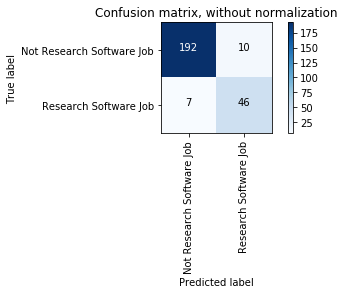

Normalized confusion matrix
[[0.95 0.05]
 [0.13 0.87]]


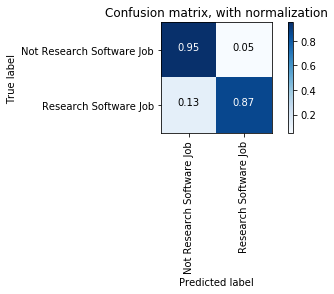

In [12]:
plt.figure()
plot = plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization', normalize=False)
plt.show();

plt.figure()
plot = plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, with normalization', normalize=True)
plt.show();
#plt.savefig('../outputs/dataPrediction/confusion_matrix_normalised.png', dpi=300, bbox_inches='tight')

## Scatter plot

In [13]:
def color_right(x, y):
    col = list()
    for i, j in zip(x, y):
        if i < 0.65 and j < 0.5:
            col.append('g')
        elif i < 0.65 and j > 0.5:
            col.append('r')
        elif i > 1 and j > 0.5:
            col.append('g')
        elif i > 1 and j < 0.5:
            col.append('r')
        elif i == 1:
            col.append('grey')
        else:
            col.append('darkorange')
    return col

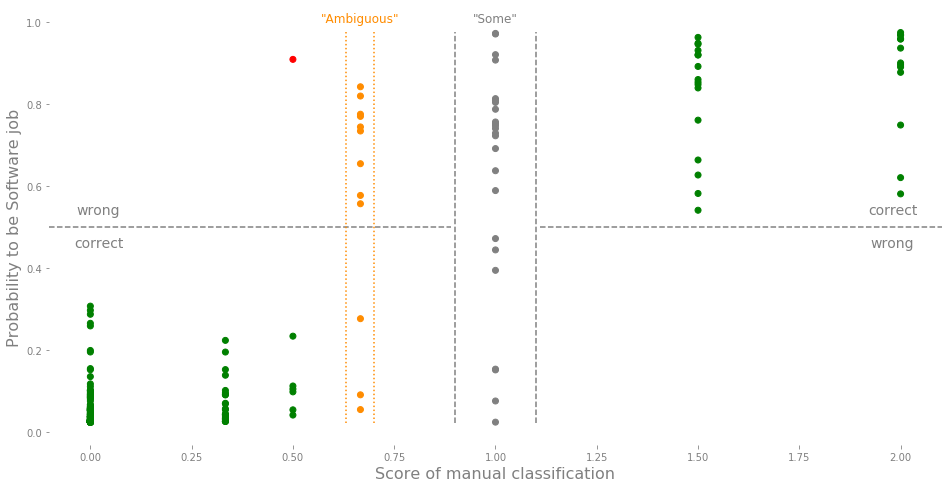

In [14]:
# Get a scatter plot to see the relation between the agg_tag score and the prediction proba to see where the model failed
# It seems to performing relatively according to expectation. There is a confusing point when aggregate score == 1
# and when the aggregate score is between 0.5 and 0.75 where it appears to classify it as in the opposite direction
# These score seems to represent ambiguious score where people have opposite views on the jobs ads. 

tag_creat = [abs(x) for x in training['agg_tag'] if abs(x) < 10]
pred_inv = [x for x in  training[training['agg_tag'] > -10]['prediction_proba']]

col = color_right(tag_creat, pred_inv)

fig, ax = plt.subplots(figsize=(16, 8))

plt.axhline(y=0.5, xmax=0.45, color='grey', linestyle='--')
plt.axvline(x=0.9, ymin=0.05, ymax=0.95, color='grey', linestyle='--')

plt.axhline(y=0.5, xmin=0.55, color='grey', linestyle='--')
plt.axvline(x=1.1,ymin=0.05, ymax=0.95, color='grey', linestyle='--')

plt.axvline(x=0.63, ymin=0.05, ymax=0.95, color='darkorange', linestyle=':')
plt.axvline(x=0.70,ymin=0.05, ymax=0.95, color='darkorange', linestyle=':')
plt.text(0.666,1,'"Ambiguous"', color='darkorange', fontsize=12, horizontalalignment='center')

plt.text(1,1,'"Some"', color='grey', fontsize=12, horizontalalignment='center')

plt.text(1.98,0.53,'correct', color='grey',fontsize=14, horizontalalignment='center')
plt.text(0.02,0.45,'correct', color='grey',fontsize=14, horizontalalignment='center')
plt.text(1.98,0.45,'wrong', color='grey', fontsize=14, horizontalalignment='center')
plt.text(0.02,0.53,'wrong', color='grey', fontsize=14, horizontalalignment='center')

ax.set_ylabel('Probability to be Software job', fontsize=16, color='grey')
ax.tick_params(axis='y', colors='grey')

ax.set_xlabel('Score of manual classification', fontsize=16, color='grey')
ax.tick_params(axis='x', colors='grey')

plt.scatter(tag_creat, pred_inv, color=col)

#ax.xlabel('Score of manual classification', fontsize=14, color='grey')
for d in ["left", "top", "bottom", "right"]:
    plt.gca().spines[d].set_visible(False)


## Details on each problematic classifications

 ### Ambiguous classification

In [15]:
training[(training['agg_tag'] > 0.5) & (training['agg_tag'] < 1)][['jobid', 'run_tag', 'tags_1', 'tags_2', 'tags_3', 'agg_tag', 'created_tag', 'prediction', 'prediction_proba', 'corresponding_tag']]

,jobid,run_tag,tags_1,tags_2,tags_3,agg_tag,created_tag,prediction,prediction_proba,corresponding_tag
29,AJJ541,first_run,Some,Some,No,0.666667,0,1,0.774545,False
39,AJR085,first_run,Some,No,Some,0.666667,0,1,0.841471,False
58,AKC175,first_run,No,No,Most,0.666667,0,0,0.090118,True
67,AKI397,first_run,Some,Some,No,0.666667,0,1,0.818867,False
105,ALD850,first_run,No,Some,Some,0.666667,0,1,0.653838,False
156,AMI367,first_run,No,Some,Some,0.666667,0,1,0.556134,False
168,AMN906,first_run,No,No,Most,0.666667,0,0,0.275831,True
180,AMX585,first_run,Some,No,Some,0.666667,0,1,0.733577,False
183,AMZ242,first_run,Some,No,Some,0.666667,0,1,0.769226,False
189,ANG993,first_run,Some,No,Some,0.666667,0,1,0.743519,False


### 'Some' category

In [16]:
training[(abs(training['agg_tag']) ==1)][['jobid', 'run_tag', 'tags_1', 'tags_2', 'tags_3', 'agg_tag', 'created_tag', 'prediction', 'prediction_proba', 'corresponding_tag']]

,jobid,run_tag,tags_1,tags_2,tags_3,agg_tag,created_tag,prediction,prediction_proba,corresponding_tag
13,AJE987,first_run,No,InsufficientEvidence,Most,-1.0,1,0,0.150855,False
17,AJF652,first_run,Some,Some,None,1.0,1,1,0.588299,True
19,AJH016,first_run,No,Most,InsufficientEvidence,-1.0,1,0,0.393727,False
23,AJI375,first_run,Some,Some,None,1.0,1,1,0.751355,True
26,AJJ046,first_run,InsufficientEvidence,Some,Some,-1.0,1,1,0.803341,True
27,AJJ266,first_run,Most,No,Some,1.0,1,1,0.970134,True
31,AJM416,first_run,InsufficientEvidence,No,Most,-1.0,1,1,0.690741,True
37,AJP432,first_run,Some,Some,None,1.0,1,1,0.739693,True
46,AJX808,first_run,InsufficientEvidence,Most,No,-1.0,1,0,0.152786,False
48,AJY559,first_run,InsufficientEvidence,Some,Some,-1.0,1,1,0.721914,True


### insufficient evidence

In [17]:
training[(training['agg_tag'] <0)][['jobid', 'run_tag', 'tags_1', 'tags_2', 'tags_3', 'agg_tag', 'created_tag', 'prediction', 'prediction_proba', 'corresponding_tag']]

,jobid,run_tag,tags_1,tags_2,tags_3,agg_tag,created_tag,prediction,prediction_proba,corresponding_tag
13,AJE987,first_run,No,InsufficientEvidence,Most,-1.0,1,0,0.150855,False
18,AJG800,first_run,InsufficientEvidence,InsufficientEvidence,None,-10.0,0,0,0.190167,True
19,AJH016,first_run,No,Most,InsufficientEvidence,-1.0,1,0,0.393727,False
25,AJI975,first_run,Most,InsufficientEvidence,InsufficientEvidence,-10.0,0,0,0.049979,True
26,AJJ046,first_run,InsufficientEvidence,Some,Some,-1.0,1,1,0.803341,True
31,AJM416,first_run,InsufficientEvidence,No,Most,-1.0,1,1,0.690741,True
32,AJM565,first_run,InsufficientEvidence,No,Some,-0.5,0,0,0.040731,True
46,AJX808,first_run,InsufficientEvidence,Most,No,-1.0,1,0,0.152786,False
48,AJY559,first_run,InsufficientEvidence,Some,Some,-1.0,1,1,0.721914,True
51,AJY914,first_run,Most,Some,InsufficientEvidence,-1.5,1,1,0.852623,True


### Wrongly classified jobs

#### Description of the wrongly classify as Software job

In [18]:
training[(abs(training['agg_tag']) < 0.55) &(training['prediction_proba'] > 0.5)][['jobid', 'run_tag', 'tags_1', 'tags_2', 'tags_3', 'agg_tag', 'created_tag', 'prediction', 'prediction_proba', 'corresponding_tag']]

,jobid,run_tag,tags_1,tags_2,tags_3,agg_tag,created_tag,prediction,prediction_proba,corresponding_tag
133,ALS409,first_run,Some,InsufficientEvidence,No,-0.5,0,1,0.908283,False


In [19]:
wrong_soft = training[(abs(training['agg_tag']) < 0.55) &(training['prediction_proba'] > 0.5)]['description']
for i in wrong_soft:
    print(i)


   Closing date :  03/09/2015 
 Reference :  LSX-06901 
 Faculty / Organisational unit :  Life Sciences  
 Division :  Tissue Systems 
 Employment type :  Fixed Term 
 Duration :  from 01/10/2015 until 30/09/2018 
 Location :  Oxford Road, Manchester 
 Salary :  £30,434 - £37,394 per annum 
 Hours per week :  Full time 
 
 
 You will be a self-motivated Researcher with extensive experience of vascular biological studies in the zebrafish (Danio Rerio) model system for a BBSRC-funded Research Associate position (laboratory of Dr. Shane Herbert). The project will investigate the regulation of endothelial cell behaviour during new blood vessel sprouting in the zebrafish model system. In particular, the project will integrate in vivo cell biological studies in zebrafish with in vitro studies in endothelial cells and computational modelling (in collaboration with K. Bentley, Harvard, USA) to identify novel determinants of vascular cell behaviour in angiogenesis. 
 You will either already ho

#### Description of the wrongly classify as NOT Software job

In [20]:
training[(abs(training['agg_tag']) > 1) & (abs(training['agg_tag']) < 10) &(training['prediction_proba'] < 0.5)][['jobid', 'run_tag', 'tags_1', 'tags_2', 'tags_3', 'agg_tag', 'created_tag', 'prediction', 'prediction_proba', 'corresponding_tag']]

,jobid,run_tag,tags_1,tags_2,tags_3,agg_tag,created_tag,prediction,prediction_proba,corresponding_tag


In [21]:
wrong_not = training[(abs(training['agg_tag']) > 1) & (abs(training['agg_tag']) < 10) &(training['prediction_proba'] < 0.5)]['description']
for i in wrong_not:
    print(i)